# Parte II - Extracción de las series de tiempo a través de Yahoo Finance y arquitectura LSTM

### 1. Carga de los datos y tratamiento

In [2]:
import torch
import pandas as pd
import numpy as np

torch.__version__

'2.3.1+cu121'

In [3]:
torch.manual_seed(77)

In [4]:
import yfinance as yf

data = yf.download('TSLA', start='2019-01-01', end='2024-11-01', interval='1d')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-01-02 00:00:00+00:00,20.674667,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03 00:00:00+00:00,20.024000,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04 00:00:00+00:00,21.179333,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07 00:00:00+00:00,22.330667,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08 00:00:00+00:00,22.356667,22.356667,22.934000,21.801332,22.797333,105127500


In [5]:
data.shape

(1469, 6)

### 2. Visualización de los datos

<Axes: title={'center': 'Adj Price TESLA'}, xlabel='Time', ylabel='Price'>

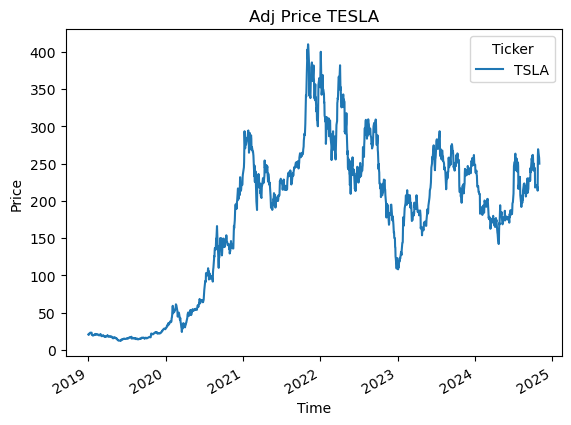

In [6]:
import matplotlib.pyplot as plt

data_adj = data['Adj Close'].dropna()

data_adj.plot(title='Adj Price TESLA', xlabel='Time', ylabel = 'Price')

- Para obtener mejores resultados debemos deshacernos de la estacionalidad,  del ruido y normalizar nuestras series de tiempo. Primero evaluamos tres maneras de eliminar la estacionalidad a partir del primedio de los residuales. Entre más alejado sea de 0, será el método que más nos convenga.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

des_add = seasonal_decompose(data_adj, model='additive', period=365)
des_mult = seasonal_decompose(data_adj, model='multiplicative', period=365)
des_stl = STL(data_adj, period = 365).fit()

In [8]:
des_add.resid.mean(), des_mult.resid.mean(), des_stl.resid.mean()

(2.3010124391920863, 0.9670052173817174, 1.5954741079891235)

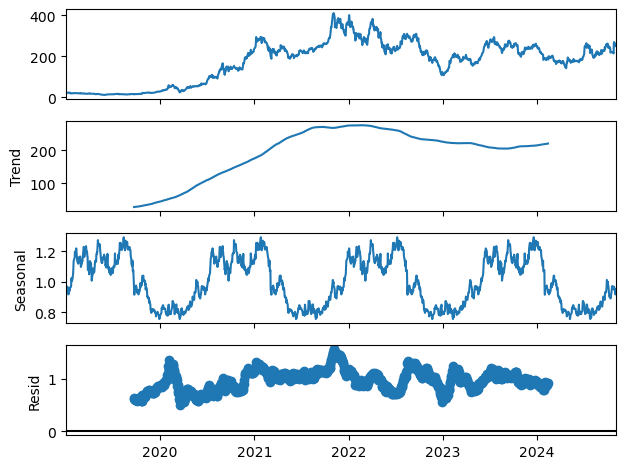

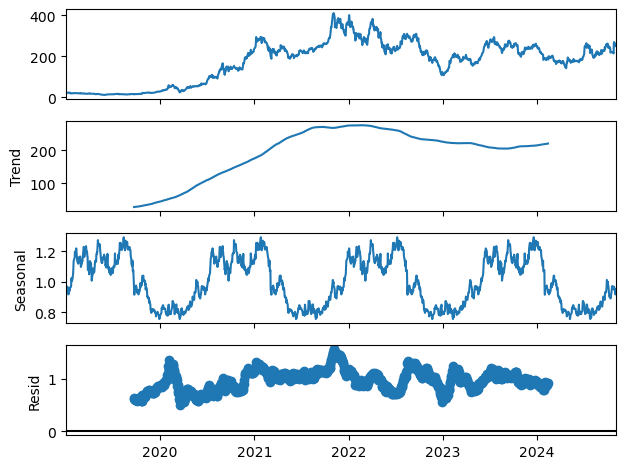

In [9]:
des_mult.plot()

- Una vez analizados los promedios residuales nos percatamos que el promedio más bajo es el de la descomposición multiplicativa, por lo que elegiremos este

In [10]:
estacionalidad = des_mult.seasonal

In [11]:
data_clean = data_adj['TSLA'] - estacionalidad

<Axes: xlabel='Date'>

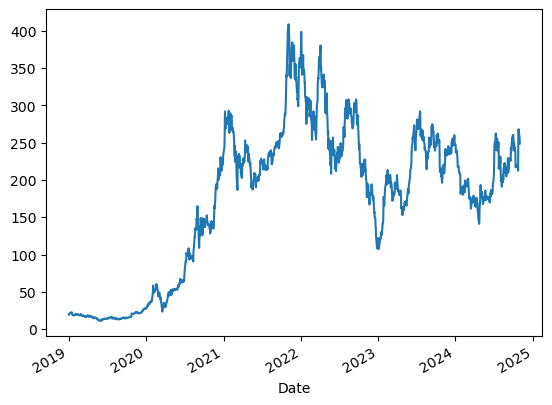

In [12]:
data_clean.plot()

In [16]:
df_process = data_clean.to_frame()

### 3. Pipeline

**Window Time**
$$t - w$$

**Window Time Predict**
$$t + 1

- Ventanas de predicción para pedirle al modelo que prediga el siguiente dato.

In [17]:
def window_time(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:(i+lookback)] #Representación de la ventana de la serie de tiempo
        target = dataset[i+lookback] #Salida que se busca predecir
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

- División y tratamiento de los datos de entrenamiento, prueba y validación

In [19]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

data_train = sc.fit_transform(df_process)

lookback = 4
X, y = window_time(data_train, lookback)

In [21]:
train_size = int(len(data_clean) * 0.67)
test_size = len(data_clean) - train_size

X_data = torch.Tensor(X)
y_data = torch.Tensor(y)

X_train = torch.Tensor(X[0:train_size])
y_train = torch.Tensor(y[0:train_size])

X_test = torch.Tensor(X[train_size:len(X)])
y_test = torch.Tensor(y[train_size:len(y)])

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([984, 4, 1]),
 torch.Size([984, 1]),
 torch.Size([480, 4, 1]),
 torch.Size([480, 1]))

### 4. Modelo - Arquitectura LSTM

In [31]:
import torch.nn as nn
from torch import optim
import time
import torch.utils.data as data

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):

        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=num_layers, 
                        batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)
        #self.relu1 = nn.ReLU()
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #Estados ocultos
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) #Celdas ocultos

        sal, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc1(h_out)

        return out

### 5. Entrenamiento

In [45]:
model = LSTM(input_size=1, hidden_size=2, num_layers=1, num_classes=1)
loss_fn = nn.MSELoss()
#loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [ ]:
def train(model, device, X_train, y_train, optimizer, epoch):

  model.train()
  X_train = X_train.to(device)
  y_train = y_train.to(device)

  outputs = model(X_train)
  optimizer.zero_grad()

  loss = loss_fn(outputs, y_train)

  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [49]:
model.to(device)

lstm_optimizer = optim.Adam(model.parameters(), lr=0.001)

In [50]:
epochs = 2000

for epoch in range(epochs):
    train(model, device, X_train, y_train, lstm_optimizer, epoch)
    #test(model, device, X_train, y_train, X_test, y_test)

Epoch: 0, loss: 0.28069
Epoch: 100, loss: 0.12451
Epoch: 200, loss: 0.07565
Epoch: 300, loss: 0.06488
Epoch: 400, loss: 0.05421
Epoch: 500, loss: 0.03949
Epoch: 600, loss: 0.02156
Epoch: 700, loss: 0.00660
Epoch: 800, loss: 0.00147
Epoch: 900, loss: 0.00108
Epoch: 1000, loss: 0.00105
Epoch: 1100, loss: 0.00104
Epoch: 1200, loss: 0.00103
Epoch: 1300, loss: 0.00101
Epoch: 1400, loss: 0.00100
Epoch: 1500, loss: 0.00099
Epoch: 1600, loss: 0.00097
Epoch: 1700, loss: 0.00096
Epoch: 1800, loss: 0.00095
Epoch: 1900, loss: 0.00093


### 6. Evaluación del modelo

<function matplotlib.pyplot.show(close=None, block=None)>

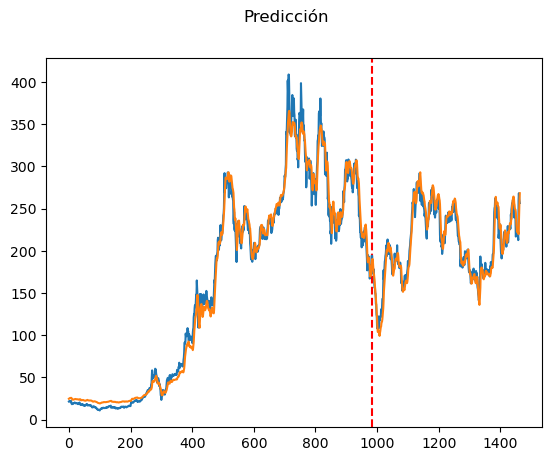

In [56]:
model.eval()

X_data = X_data.to(device)
train_predict = model(X_data)

data_predict = train_predict.data.cpu().numpy()
y_plot = y_data.data.numpy()

data_predict = sc.inverse_transform(data_predict)
y_plot = sc.inverse_transform(y_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(y_plot)
plt.plot(data_predict)
plt.suptitle('Predicción')
plt.show